In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

# Imports

# third party
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True)
import pandas as pd

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

#need to get rid of
import numpy as np

# project
from dynamicAll import models

In [3]:
# load test_data
rawdata = pd.read_csv('data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_100_3.dat')

R = jnp.sqrt(jnp.array(rawdata['x']**2+rawdata['y']**2))
indices = jnp.argsort(R)
vlos = jnp.array(rawdata['vz'])

data = jnp.array([R[indices],vlos[indices]])
data.shape

error = jnp.full_like(vlos,2)

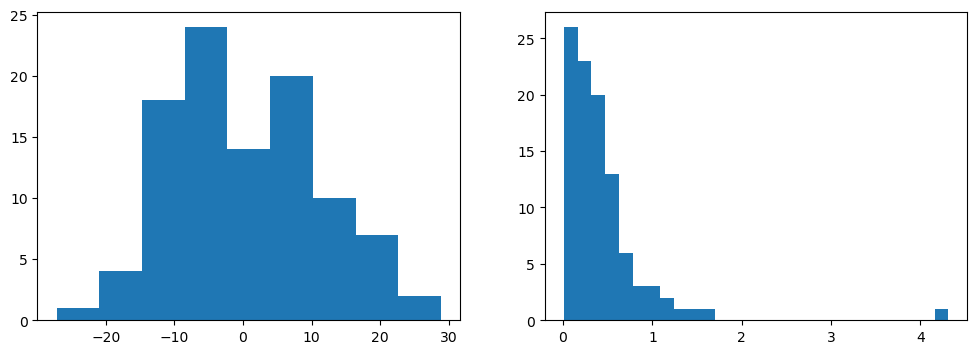

In [4]:
#visualize data

fig,ax = plt.subplots(figsize=(12,4),ncols=2)

ax[0].hist(vlos,bins='auto')
ax[1].hist(R,bins='auto');

In [5]:
# set up model
# ------------
# model for tracers
tracer_model = models.Plummer  # other options include exponential, king,
n_tracer     = 1               # number of plummer components to fit to data

# stellar anisotropy model
beta_model = models.gOM #options: constant, OM (osipkov-merrit), gOM (for cases with tangential orbits are possible)

# Do you want to fit multiple metallicity components
n_pop = 1 # number of metallicity components

dm_model = models.HernquistZhao # other options are NFW, gNFW, exponential
n_dm     = 1                    # number of dm components to fit 


AttributeError: module 'dynamicAll.models' has no attribute 'gOM'

In [6]:
#temporary
G  = 4.5171031e-39 # Gravitational constant [kpc**3 solMass**-1 s**-2] 
#need different accuracy for each integral
xmass,wmass  = np.loadtxt('/Users/juan/phd/projects/dynamicAll/src/data/gausleg_10',delimiter=',')

xmass = jnp.array(xmass)
wmass = jnp.array(wmass)

xdisp,wdisp  = np.loadtxt('/Users/juan/phd/projects/dynamicAll/src/data/gausleg_10',delimiter=',')

xdisp = jnp.array(xdisp)
wdisp = jnp.array(wdisp)

@jax.jit
def density(r,rhos : float,rs : float, a : float, b : float, c : float):
    '''
    Hernquist-Zhao density profile

    Parameters
    ----------
    r : _type_
        _description_
    rhos : float
        _description_
    rs : float
        _description_
    a : float
        _description_
    b : float
        _description_
    c : float
        _description_

    Returns
    -------
    _type_
        _description_
    '''
    q = r/rs
    nu = (a-c)/b
    return rhos * q**-a * (1+q**b)**(nu)

density_grad = jax.vmap(jax.grad(density),in_axes=(0,None,None,None,None,None))


from dynamicAll.models import JeansOM

def logslope(r,rhos,rs,a,b,c):
    return -r*density_grad(r,rhos,rs,a,b,c)/density(r,rhos,rs,a,b,c)


x0 = 0.0
x1 = jnp.pi/2

# Gauss-Legendre integration
xi = 0.5*(x1-x0)*xmass + .5*(x1+x0) # scale from (r,r_{200}) -> (-1,1)
wi = 0.5*(x1-x0)*wmass
s = jnp.cos(xi)
w = jnp.sin(xi)

@jax.jit
def mass_integral(r,rhos,rs,a,b,c):
    q = r/rs 
    coeff = 4*jnp.pi * rhos*rs**2* q
    # return coeff*jnp.sum(wi*jnp.cos(xi)*(r*jnp.sin(xi))**2 * density(r*jnp.sin(xi),1.0,1.0,a,b,c))
    return coeff*jnp.sum(wi*s*(q*w)**2 * density(q*w,1.0,1.0,a,b,c))

vec_mass  = jax.vmap(mass_integral,in_axes=(0, None,None,None, None,None))

vec_mass  = jax.vmap(mass_integral,in_axes=(0, None,None,None, None,None))
# mass = vec_mass(r,rhos,rs,a,b,c)

# vec_mass  = jax.vmap(JeansOM.mass,in_axes=(0, None,None,None, None,None))
@jax.jit
def func(q,rhos,rs,a,b,c):

    return vec_mass(q,rhos,rs,a,b,c)*JeansOM.nu(q,0.25)/q**2
@jax.jit
def dispersion_integral(r,rhos,rs,a,b,c):
    x0 = 0.0
    x1 = jnp.pi/2.0

    # Gauss-Legendre integration
    xi = 0.5*(x1-x0)*xdisp + .5*(x1+x0)
    wi = 0.5*(x1-x0)*wdisp
    coeff = G*r

    return coeff*jnp.sum(wi*jnp.cos(xi)*func(r/jnp.sin(xi),rhos,rs,a,b,c)/jnp.sin(xi)**2,axis=0)

vec_dispn = jax.vmap(dispersion_integral,in_axes=(0,None, None,None,None,None)) # this is the Gauss-Legendre method




@jax.jit
def func2(x,R_,rhos,rs,a,b,c):
    sn = vec_dispn(x,rhos,rs,a,b,c)
    return sn*x/jnp.sqrt(x**2-R_**2)


y0 = 0        # lowerbound 
y1 = jnp.pi/2 # upperbound
# Modified weights and points for 
xk = 0.5*(y1-y0)* xdisp + 0.5*(y1+y0) 
wk = 0.5*(y1-y0)* wdisp 

cosk= jnp.cos(xk)
sink = jnp.sin(xk)
@jax.jit
def test_dispersion(R_: float,rhos: float,rs: float,a: float,b: float,c: float) -> float:
    '''
    first using the transform y = rcsc(x)
    then using Gauss-Legendre transformation.
    using the transform x = 
    '''
    rhos= jnp.exp(rhos)
    rs = jnp.exp(rs)
    # y0 = 0        # lowerbound 
    # y1 = jnp.pi/2 # upperbound
    # # Modified weights and points for 
    # xk = 0.5*(y1-y0)* xdisp + 0.5*(y1+y0) 
    # wk = 0.5*(y1-y0)* wdisp 
    # return 2* R_* jnp.sum(wk*jnp.cos(xk)*func2(R_/jnp.sin(xk),R_,rhos,rs,a,b,c)/jnp.sin(xk)**2,axis=0)/JeansOM.projected_stars(R_,0.25)
    return 9.5214061e32*2* R_* jnp.sum(wk*cosk*func2(R_/sink,R_,rhos,rs,a,b,c)/sink**2,axis=0)/JeansOM.projected_stars(R_,0.25)

vec_dispb = jax.vmap(test_dispersion,in_axes=(0, None, None,None,None,None))

FileNotFoundError: /Users/juan/phd/projects/dynamicAll/src/data/gausleg_10 not found.

In [7]:
r = jnp.logspace(-2,1,100)
# NFW
rhos = np.log(6.4e7)
rs   = np.log(1.0)
a    = 1.0 
b    = 1.0
c    = 3.0

disp_test = vec_dispb(r,rhos,rs,a,b,c)
disp_test2 = vec_dispb(r,np.log(1e7),np.log(2),0,b,c)
import astropy.units as u
fig,ax = plt.subplots()

ax.plot(r,jnp.sqrt(disp_test),lw=3,label = 'fixed integration')
ax.plot(r,jnp.sqrt(disp_test2),lw=3,label = 'fixed integration')
# ax.plot(r,jnp.sqrt((G*testdisp4*u.kpc**2/u.s**2).to(u.km**2/u.s**2).value),lw=3,label = 'scipy',linestyle='--')
ax.axvline(0.25,linestyle='--',label=r'$r_{s,\star}$')
ax.axvline(1,linestyle='--',label=r'$r_{s,dm}$')
ax.set(
    xlabel = r'r [kpc]',
    ylabel = r'$\sigma_{\mathrm{los}}(r)$',
    xscale='log',
    # yscale='symlog'
    xlim  = (.01,10),
    ylim=(0,15), 
)
plt.legend(fontsize=14)



NameError: name 'vec_dispb' is not defined

In [8]:
# output = ndjeans.fit(data,errors,tracer_model,beta_model,dm_model)

In [9]:
def model_flat(data,error):
    m_rhos = numpyro.sample("m_rhos", dist.Uniform(5,25))   # \ln{scale density} -- dont want negatives 
    m_rs   = numpyro.sample("m_rs", dist.Uniform(-10,3))  # \ln{scale density} -- dont want negatives 
    m_a    = numpyro.sample("m_a", dist.Uniform(-1,5))
    v      = numpyro.sample("v_mean", dist.Uniform(-100,100))
    m_re = numpyro.deterministic('m_re'   ,mass_integral(0.25,jnp.exp(m_rhos),jnp.exp(m_rs),m_a,1,3))
    with numpyro.plate("data", len(data[1,:])):
        sigma =jnp.sqrt(vec_dispb(data[0,:],m_rhos,m_rs,m_a,1,3))
        numpyro.sample("y", dist.Normal(v,sigma), obs=data[1:])

In [10]:
# Start from this source of randomness. We will split keys for subsequent operations.
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS 
kernel = NUTS(model_flat)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_,data= data,error=error)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [06:31<00:00,  7.66it/s, 47 steps of size 8.71e-02. acc. prob=0.67] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       m_a      0.52      0.76      0.66     -0.68      1.55     11.65      1.18
    m_rhos     18.47      1.43     18.67     16.19     20.36      7.19      1.27
      m_rs     -0.30      1.19     -0.53     -1.77      1.53      6.45      1.30
    v_mean      0.79      1.27      0.72     -0.87      2.99     20.90      1.06

Number of divergences: 242


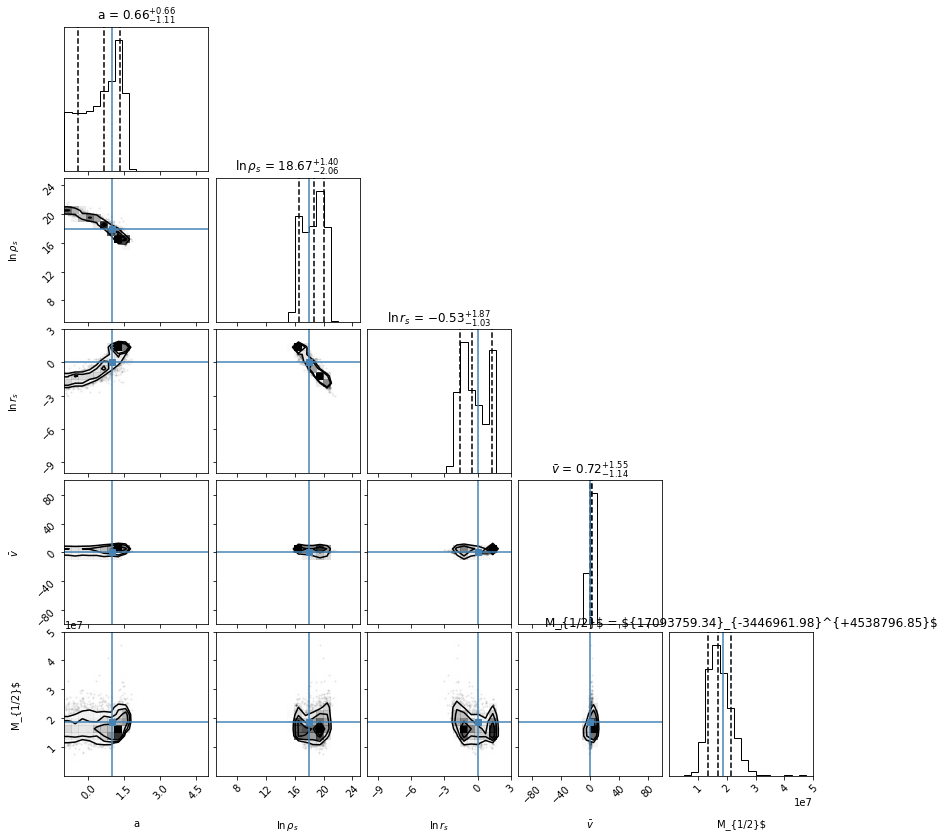

In [19]:
import corner
import arviz as az
corner.corner(samples_1,
# bins=20,
var_names=['m_a','m_rhos','m_rs','v_mean','m_re'],
labels=['a','$\ln{\\rho_s}$',r'$\ln{r_s}$',r'$\bar{v}$',r'M_{1/2}$'],
quantiles=[0.16, 0.5, 0.84],
show_titles=True,truths=[1,np.log(6.4e7),np.log(1),0,mass_integral(0.25,6.4e7,1,1,1,3)],
range=np.array([[-1,5],[5,25],[-10,3],[-100,100],[1e4,5e7]]),
# range=np.array([[-1,3],[5,25],[-10,3],[-100,100]]),
# levels=(1 - jnp.exp(-0.5),)
);

In [12]:
truths=[1,np.log(6.4e7),np.log(1),0]
truths

[1, 17.974393641323946, 0.0, 0]

In [13]:
import numpy as np
np.exp(-5)

0.006737946999085467

In [14]:
mass_integral(0.25,6.4e7,1,1,1,3)

DeviceArray(18613148.36139513, dtype=float64)